# Subject Data PreProcessing
* find subject data
* concatenate the inter-session data
* concatenate the intra-session data
* Clean and condense the data
* Create graphs

# TO DO
* DONE - Adapt the cleaning cell to also consider empty data points and mark them as noData in the DataFrame
    * IN PROGRESS - Make sure that the timestamps are consistent!
    * DONE - Check for possible condition for noData points, e.g. unsufficient eye-openness
    * DONE - Adapt script to rename all colliders to NoHouse that are no house (house list required)
    * DONE - adjust nan dataframes to also add sessions
    * DONE - check for Graffities and replace them with building name
    * IN PROGRESS - Check for Garage Colliders
* DONE - Condense data by replacing identical successive collider hits with (collidername, amount if hits)
    * IN PROGRESS - confirm that the gaze-noise ratio is correct
* DONE - Account for lost data by interpolation! 
* DONE - Write gaze definition cell by assigning 21 consecutive hits to a gaze caused by an actual fixation. Mark hits<21 as noise 
* DONE - Create unweighted undirected graphs
    * Remove all noHouse hits 
    * Remove all self repetitions 
    * Check the exact procedure 


## Configuration

In [1]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

## Checking for missing packages

In [2]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Creating the required environment (skip if already done)

Running the following cell will create a file graphs.yml that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.

In [4]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

Overwriting graphs.yml


### Environment Creation
To create the environment, open the terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
conda env create -f graphs.yml
After running this command you have to activate the environment (Linux/MacOS: conda activate graphs, Windows: activate graphs) and then reopen the notebook in that environment.

## Main Part

### Imports and directory information

In [4]:
import os
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import glob
import scipy.cluster.vq as clusters
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import normalize
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 


OG_DATA_PATH = './'
THEORETICAL_DATA_PATH = './Data Exploration/'
THEORETICAL_PROCESSED_DATA_PATH = './Results/'
RESSOURCES_PATH = './Ressources/'

# Reset the Datapath since the data is not yet on Git, comment out if data is on Git 
DATA_PATH = '/Volumes/EXTENSION/Uni/Study Project/Data Exploration/'

PROCESSED_DATA_PATH = '/Volumes/EXTENSION/Uni/Study Project/Results/'
# Getting the Folder without hidden files in ascending order 
DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)
PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

### Extracting all subject IDs from the data folder

In [8]:
subIDs = []
for sub in DATA_FOLDER:
    if sub[0].isdigit():
        subIDs.append(int(sub[0:4]))
    else:
        pass
subIDs = np.unique(subIDs)
print(subIDs)

[1013 1019 1023 1079 1080 7357]


In [5]:
# custom subID
subIDs = [1023]

### Combine the data
* Loop through all subjects
* extract the session data
* combine the data
* save it

In [155]:
# --------- Preparation ---------

Session_save_bool = False # set to True if you want to save each individual session as csv
Exploration_save_bool = True # set to True if you want to save the complete exploration as csv
subcount = 0
graffity_replaced_count = 0
removed_body_hits = 0
removed_nohouse_hits = 0

landmarks = ['Castle-TaskBuilding_56',
             'Church-TaskBuilding_16',
             'HighSilo-TaskBuilding_49',
             'Windmill-TaskBuilding_10_1']


# column name list for dataframe
col_names =  ['Session',
              'timeStampDataPointStart',
              'timeStampDataPointEnd',
              'hitObjectColliderName', 
              'ordinalOfHit',
              'BitMask',
              'hitPointOnObject.x',
              'hitPointOnObject.y',
              'hitPointOnObject.z',
              'hitObjectColliderBoundsCenter.x',
              'hitObjectColliderBoundsCenter.y',
              'hitObjectColliderBoundsCenter.z']


NoHit_dict = {'hitPointOnObject': {'x': 'NaN',
                                   'y': 'NaN',
                                   'z': 'NaN'},
              'hitObjectColliderName': 'NoHit',
              'hitObjectColliderBoundsCenter': {'x': 'NaN',
                                                'y': 'NaN',
                                                'z': 'NaN'},
              'ordinalOfHit': '1',
              'Session': 'NaN',
              'timeStampDataPointStart': 'NaN',
              'timeStampDataPointEnd': 'NaN',
              'BitMask': 'NaN'}

#houselist 
house_file = RESSOURCES_PATH + 'building_names.pickle'
try:
    houselist = pd.read_pickle(house_file)
except:
    print('HouseList could not be loaded!')

# --------------------------- MAIN PART ---------------------------


# --------- first layer - subject loop ---------

for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # Create empty dataframe for later concatenation
    complete_exploration_df = pd.DataFrame(columns = col_names)
    
    # get the data files according to the subject, ignoring OnQuit files
    subject_folder = sorted([f for f in DATA_FOLDER 
                             if f.startswith(str(subject)+'_Expl_S_') and f.endswith("OnQuit.json") == False], 
                            key=str.lower) 
    
    # the following works as long as the data name format is as follows:
    # 'subjectID'_Expl_S_'SessionNumber'_ET_'EyeTrackingSessionNumber'_'UnixTimestamp'.json
    folder_files = list()
       
    # loop through the subject folder and save all numbers
    for file in subject_folder:
        folder_files.append(re.findall(r'\d+', file))
    
    # Extract all SubIDs (only one), SessionNumbers, ET_SessionNumbers (and Timestamps)
    SubID, SessionNumbers, ET_SessionNumbers, UnixTimestamp1, UnixTimeStamp2 = map(list, zip(*folder_files))
    
    session_number = int(max(SessionNumbers)) # the maximum session number of the particular subject
    
    
# --------- second layer - exploration session loop ---------

    # loop over exploration sessions
    for EXP_session in range(session_number):
        # to avoid start at 0
        EXP_session +=1 

        # extract the exploration data
        subject_data = sorted([f for f in DATA_FOLDER if f.startswith(str(subject) + '_Expl_S_' + str(EXP_session)) 
                               and f.endswith("OnQuit.json") == False], key=str.lower)

        
        # hitpoint dataframe 
        complete_hitpoints_df = pd.DataFrame(columns = col_names)

        print("\tTotal Sessionfiles: "
              + str(len(subject_data))
              + " - Exploration Session "
              + str(EXP_session))
        
        s = 0 # session count
        
# --------- third layer - eye tracking session loop ---------

        # loop over separate eye tracking sessions
        for ET_session in subject_data:
            s+=1

            # open the JSON file as dictionary
            with open(DATA_PATH + ET_session) as f:
                try:
                    subject_session = json.loads(f.read())
                except:
                    print("\tJSON file " + ET_session + " is not valid!")

            hitpoints_df = pd.DataFrame(columns = col_names)
            hitpoint_list = list() # create hitpoint list

            # start timestamp of the session 
            start_time = subject_session['trials'][0]['timeTrialMeasurementStarted']

            # amount of datapoints 
            Len_subses = len(subject_session['trials'][0]['dataPoints'])

            # for loop appending each data point rayCastHit Data
            # afterwards adding the timestamp to the dict 
            # passing if there is (1) no raycast hit and (2) if there is only one raycast hit
            
            # --------------- First order hits! ---------------
            for each in subject_session['trials'][0]['dataPoints']:

                # ----- account for noHits ----- 
                if each['rayCastHitsCombinedEyes'] == []:
                    hitpoint_list.append(NoHit_dict)
                    # set index for new entry
                    idx = len(hitpoint_list)-1
                    hitpoint_list[idx]['Session'] = EXP_session
                    hitpoint_list[idx]['timeStampDataPointStart'] = each['timeStampDataPointStart'] - start_time
                    hitpoint_list[idx]['timeStampDataPointEnd'] = each['timeStampDataPointEnd'] - start_time
                else:
                    # ----- append data point -----
                    hitpoint_list.append(each['rayCastHitsCombinedEyes'][0])
                    # set index for new entry
                    idx = len(hitpoint_list)-1
                    
                    # add Session, timestamp and bitmask
                    hitpoint_list[idx]['Session'] = EXP_session
                    hitpoint_list[idx]['timeStampDataPointStart'] = each['timeStampDataPointStart'] - start_time
                    hitpoint_list[idx]['timeStampDataPointEnd'] = each['timeStampDataPointEnd'] - start_time
                    hitpoint_list[idx]['BitMask'] = each['combinedGazeValidityBitmask']                    
                    
                    # ----- check for different conditions: ----- 
                    
                    # ----- NoHouse Hits -----
                    # check if the collider name is a member of the houselist - if not: rename to NoHouse 
                    if (hitpoint_list[idx]['hitObjectColliderName'] in houselist) == False \
                    and hitpoint_list[idx]['hitObjectColliderName'] != 'Body' \
                    and (hitpoint_list[idx]['hitObjectColliderName'].startswith('Graffity_')) == False \
                    and (hitpoint_list[idx]['hitObjectColliderName'].startswith('crane_')) == False:
                        hitpoint_list[idx]['hitObjectColliderName'] = 'NoHouse'

                        
                    # ----- Graffity Hits -----
                    ## check if there are Graffity Hits and rename them as the building they are on
                    #if hitpoint_list[idx]['hitObjectColliderName'].startswith('Graffity_'):
                    #    building_number = re.search(r'\d+', hitpoint_list[idx]['hitObjectColliderName']).group()
                    #    graffity_to_building = []
                    #    
                    #    
                    #    # if the number is between 0 and 9, remove the 0
                    #    if int(building_number) < 10:
                    #        building_number = building_number[1]
                    #        
                    #    for house in houselist:
                    #        #check if the exact building number is in the houselist to replace graffity name
                    #        # additionally check that it's not a landmark
                    #        if house.endswith('_' + building_number) and house not in landmarks:
                    #            graffity_to_building.append(house)
                    #        else:
                    #            pass
                    #        
                    #    graffity_to_building = np.unique(graffity_to_building)
                    #        
                    #    if len(graffity_to_building) == 1:
                    #        hitpoint_list[idx]['hitObjectColliderName'] = graffity_to_building[0]
                    #        graffity_replaced_count += 1
                    #    else:
                    #        print('Multiple houses with the same number! - Index: ' 
                    #              + str(idx)
                    #              + ', ' 
                    #              + str(graffity_to_building))
                    
               
         # --------------- Second order hits! ---------------
                # redo if there is a second ordinal hit
                try: 
                    # append data point of second raycast hit if it exists
                    hitpoint_list.append(each['rayCastHitsCombinedEyes'][1])
                    # set index for new entry
                    idx = len(hitpoint_list)-1
                    
                    # add Session, timestamp and bitmask
                    hitpoint_list[idx]['Session'] = EXP_session
                    hitpoint_list[idx]['timeStampDataPointStart'] = each['timeStampDataPointStart'] - start_time
                    hitpoint_list[idx]['timeStampDataPointEnd'] = each['timeStampDataPointEnd'] - start_time
                    hitpoint_list[idx]['BitMask'] = each['combinedGazeValidityBitmask']
                    
                    # check for different conditions:
                    
                    # ----- NoHouse Hits -----
                    # check if the collider name is a member of the houselist - if not: rename to NoHouse 
                    if (hitpoint_list[idx]['hitObjectColliderName'] in houselist) == False \
                    and hitpoint_list[idx]['hitObjectColliderName'] != 'Body' \
                    and (hitpoint_list[idx]['hitObjectColliderName'].startswith('Graffity_')) == False \
                    and (hitpoint_list[idx]['hitObjectColliderName'].startswith('crane_')) == False:
                        hitpoint_list[idx]['hitObjectColliderName'] = 'NoHouse'
                        
                    # if the first order hit was a NoHouse hit, but the second was not
                    if hitpoint_list[idx-1]['hitObjectColliderName'] == 'NoHouse' \
                    and hitpoint_list[idx]['hitObjectColliderName'] != 'NoHouse':
                        removed_nohouse_hits += 1
                        # replace the first order hit data
                        hitpoint_list[idx-1]['hitObjectColliderName'] = \
                        hitpoint_list[idx]['hitObjectColliderName']
                        hitpoint_list[idx-1]['hitPointOnObject.x'] = \
                        hitpoint_list[idx]['hitPointOnObject.x']
                        hitpoint_list[idx-1]['hitPointOnObject.y'] = \
                        hitpoint_list[idx]['hitPointOnObject.y']
                        hitpoint_list[idx-1]['hitPointOnObject.z'] = \
                        hitpoint_list[idx]['hitPointOnObject.z']
                        hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.x'] = \
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.x']
                        hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.y'] = \
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.y']
                        hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.z'] = \
                        hitpoint_list[idx]['hitObjectColliderBoundsCenter.z']
                        
                        # and remove the second order hit
                        del hitpoint_list[idx]
                    
                    # ----- Body Hits -----
                    # check if there is a 1 order Body hit, if yes: replace it with second order hit
                    if hitpoint_list[idx-1]['hitObjectColliderName'] == 'Body':
                        # if second order hit is not a body hit, replace first order hit
                        if hitpoint_list[idx]['hitObjectColliderName'] != 'Body':
                            removed_body_hits += 1
                            # replace the first order hit data
                            hitpoint_list[idx-1]['hitObjectColliderName'] = \
                            hitpoint_list[idx]['hitObjectColliderName']
                            hitpoint_list[idx-1]['hitPointOnObject.x'] = \
                            hitpoint_list[idx]['hitPointOnObject.x']
                            hitpoint_list[idx-1]['hitPointOnObject.y'] = \
                            hitpoint_list[idx]['hitPointOnObject.y']
                            hitpoint_list[idx-1]['hitPointOnObject.z'] = \
                            hitpoint_list[idx]['hitPointOnObject.z']
                            hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.x'] = \
                            hitpoint_list[idx]['hitObjectColliderBoundsCenter.x']
                            hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.y'] = \
                            hitpoint_list[idx]['hitObjectColliderBoundsCenter.y']
                            hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.z'] = \
                            hitpoint_list[idx]['hitObjectColliderBoundsCenter.z']

                            # and remove the second order hit
                            del hitpoint_list[idx]
                        # if second order hit is a body hit, replace first order hit with NoHit
                        else:
                            removed_body_hits += 1
                            # replace the first order hit data
                            hitpoint_list[idx-1]['hitObjectColliderName'] = 'NoHit'
                            hitpoint_list[idx-1]['hitPointOnObject.x'] = 'NaN'
                            hitpoint_list[idx-1]['hitPointOnObject.y'] = 'NaN'
                            hitpoint_list[idx-1]['hitPointOnObject.z'] = 'NaN'
                            hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.x'] = 'NaN'
                            hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.y'] = 'NaN'
                            hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.z'] = 'NaN'
                            
                            # and remove the second order hit
                            del hitpoint_list[idx]
                            
                            
                        
                    # ----- Graffity Hits -----
                    # check if there are Graffity Hits and rename them as the building they are on
                    #if hitpoint_list[idx]['hitObjectColliderName'].startswith('Graffity_'):
                    #    building_number = re.search(r'\d+', hitpoint_list[idx]['hitObjectColliderName']).group()
                    #    
                    #    # if the number is between 0 and 9, remove the 0
                    #    if int(building_number) < 10:
                    #        building_number = building_number[1]
                    #    
                    #    graffity_to_building = []
                    #    for house in houselist:
                    #        #check if the exact building number is in the houselist to replace graffity name
                    #        # additionally check that it's not a landmark
                    #        if house.endswith('_' + building_number) and house not in landmarks:
                    #            graffity_to_building.append(house)
                    #        else:
                    #            pass
                    #        
                    #    graffity_to_building = np.unique(graffity_to_building)
                    #    
                    #    if len(graffity_to_building) == 1:
                    #        hitpoint_list[idx]['hitObjectColliderName'] = graffity_to_building[0]
                    #        graffity_replaced_count += 1
                    #    else:
                    #        print('Multiple houses with the same number! - Index: ' 
                    #              + str(idx) 
                    #              + ', ' 
                    #              + str(graffity_to_building))

                except:
                    pass

            # TEST FOR GRAFFITY AND BODY HITS
            for index in range(len(hitpoint_list)):
                if hitpoint_list[index]['hitObjectColliderName'] == 'Body':
                    removed_body_hits += 1
                    hitpoint_list[index]['hitObjectColliderName'] = 'NoHit'
                    hitpoint_list[index]['hitPointOnObject.x'] = 'NaN'
                    hitpoint_list[index]['hitPointOnObject.y'] = 'NaN'
                    hitpoint_list[index]['hitPointOnObject.z'] = 'NaN'
                    hitpoint_list[index]['hitObjectColliderBoundsCenter.x'] = 'NaN'
                    hitpoint_list[index]['hitObjectColliderBoundsCenter.y'] = 'NaN'
                    hitpoint_list[index]['hitObjectColliderBoundsCenter.z'] = 'NaN'
                
                # check if there are Graffity Hits and rename them as the building they are on
                if hitpoint_list[index]['hitObjectColliderName'].startswith('Graffity_'):
                    building_number = re.search(r'\d+', hitpoint_list[index]['hitObjectColliderName']).group()
                    graffity_to_building = []


                    # if the number is between 0 and 9, remove the 0
                    if int(building_number) < 10:
                        building_number = building_number[1]

                    for house in houselist:
                        #check if the exact building number is in the houselist to replace graffity name
                        # additionally check that it's not a landmark
                        if house.endswith('_' + building_number) and house not in landmarks:
                            # check if the house name is already in the list
                            if house in graffity_to_building:
                                pass
                            else:
                                graffity_to_building.append(house)
                        else:
                            pass
                    if len(graffity_to_building) == 1:
                        hitpoint_list[index]['hitObjectColliderName'] = graffity_to_building[0]
                        graffity_replaced_count += 1
                    else:
                        print('Multiple houses with the same number! - Index: ' 
                              + str(index)
                              + ', ' 
                              + str(graffity_to_building))
            
            
            
            
            
            
            # normalize the hitpoint dictionary to get dataframe
            hitpoints_df = pd.json_normalize(hitpoint_list)
            
            print("\tEXP: " 
                  + str(EXP_session) 
                  + ", ET: " + str(s) 
                  + " normalized - Length: " 
                  + str(len(hitpoints_df)))
            
            complete_hitpoints_df = complete_hitpoints_df.append(hitpoints_df)

            
        # --------- Saving each Session ---------
        
        # If you want to save each session separately, set 'Session_save_bool' to True
        if Session_save_bool == True:
            try:
                if len(subject_data) > 0:
                    complete_hitpoints_df.to_csv(PROCESSED_DATA_PATH
                                                 + str(subject)
                                                 + "_CompleteSession"
                                                 + str(EXP_session)
                                                 + "_Hitpoints.csv")
                    print("\t"
                          + str(subject)
                          + " session "
                          + str(EXP_session)
                          + " saved ")
                else: 
                    print("\t"
                          + str(subject)
                          + " - Session "
                          + str(EXP_session)
                          + " is empty!")
            except:
                print("\tCould not save subject "
                      + str(subject)
                      + " session "
                      + str(EXP_session)
                      + "!")


        
        # fill the complete exploration dataframe with the separate session data (combining the sessions)
        complete_exploration_df = complete_exploration_df.append(complete_hitpoints_df)
        
    # --------- Saving the Exploration ---------
    
    # If you want to save the exploration file, set 'Exploration_save_bool' to True
    if Exploration_save_bool == True:
        # saving the complete exploration
        try:
            complete_exploration_df.to_csv(PROCESSED_DATA_PATH 
                                           + str(subject) 
                                           + "_CompleteExploration_Hitpoints.csv")
            print("\t" + str(subject) + " exploration saved")
        except:
            print("\tCould not save subject " + str(subject) + " exploration data!")
    
    
    print("\t" + str(subject) + " - Stats: ")
    print("\tRemoved Body Hits: " 
          + str(removed_body_hits) 
          + ' Removed Graffities: ' 
          + str(graffity_replaced_count) 
          + ' Removed 2nd NoHouse hits: ' 
          + str(removed_nohouse_hits))


    # Some information about the data
    bit_prop = np.sum(complete_exploration_df['BitMask'] != 3) \
        / len(complete_exploration_df)
    noHit_prop = np.sum(complete_exploration_df['hitObjectColliderName'] == 'NoHit') \
        / len(complete_exploration_df)
    noHouse_prop = np.sum(complete_exploration_df['hitObjectColliderName'] == 'NoHouse') \
        / len(complete_exploration_df)

    print("\tPortion of insufficient data quality (BitMask): " 
          + str("{:.2f}".format(bit_prop)) 
          + '%') 
    print("\tNoHits: " 
          + str("{:.2f}".format(noHit_prop)) 
          + '%')
    print("\tNoHouse: " 
          + str("{:.2f}".format(noHouse_prop)) 
          + '%')
    print("\tTotal missing data: " 
          + str("{:.2f}".format(bit_prop + noHit_prop)) 
          + '%') 



print('Done')

Subject 1023 started - 1/1
	Total Sessionfiles: 3 - Exploration Session 1
	EXP: 1, ET: 1 normalized - Length: 121053
	EXP: 1, ET: 2 normalized - Length: 120952
	EXP: 1, ET: 3 normalized - Length: 124587
	Total Sessionfiles: 3 - Exploration Session 2
	EXP: 2, ET: 1 normalized - Length: 120562
	EXP: 2, ET: 2 normalized - Length: 127697
	EXP: 2, ET: 3 normalized - Length: 128946
	Total Sessionfiles: 3 - Exploration Session 3
	EXP: 3, ET: 1 normalized - Length: 126311
	EXP: 3, ET: 2 normalized - Length: 128938
	EXP: 3, ET: 3 normalized - Length: 127901
	Total Sessionfiles: 3 - Exploration Session 4
	EXP: 4, ET: 1 normalized - Length: 125282
	EXP: 4, ET: 2 normalized - Length: 127676
	EXP: 4, ET: 3 normalized - Length: 127844
	Total Sessionfiles: 3 - Exploration Session 5
	EXP: 5, ET: 1 normalized - Length: 123371
	EXP: 5, ET: 2 normalized - Length: 128536
	EXP: 5, ET: 3 normalized - Length: 125718
	1023 exploration saved
	1023 - Stats: 
Removed Body Hits: 65990 Removed Graffities: 89010 Re

### Condense the data and create gaze lists
* Do Runlength Encoding on the colliderName column to reduce the data size

### Interpolation of the data to minimize cut clustering (based on Walter, 2021)
* Interpolation criteria:
    * there are <=21 consecutive NoHit Samples
    * they are surrounded by two clusters on the same collider

In [26]:
# --------- Preparation ---------
RLE_save_bool = False # if you want to save the condensed dataframe
Interpolation_save_bool = True # if you want to save the condensed dataframe

# column names for the condensed df
condense_col_names = ['Session', 
                      'ColliderName',
                      'Samples',]

# column names for the interpolation df
interpol_col_names = ['ColliderName',
                      'Samples',
                      'Index']

subcount = 0 # count subjects
interpolated_data = pd.DataFrame(columns=interpol_col_names) # create empty df for interpolation
current_collider = 'X' # the reference collidername for interpolation
last_hits = 0 # the reference hit sum for interpolation 





# --------- MAIN PART ---------
# load the files 
for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in PROCESSED_DATA_FOLDER 
                             if f.startswith(str(subject)+'_CompleteExploration_Hitpoints')], key=str.lower)
    
    # open the JSON file as dictionary
    with open(PROCESSED_DATA_PATH + subject_folder[0]) as f:
        try:
            data = pd.read_csv(f)
        except:
            print("\tCSV file " + subject_folder[0] + " is not valid!")
           
    data = data[data.ordinalOfHit==1]
    data.reset_index(inplace=True, drop=False)
    
    
    # --------- CONDENSE PART ---------
    # dataframe for counting successive appearances
    condense_df = pd.DataFrame(index=range(len(data)), columns=condense_col_names)
    condense_df.Session = data.Session
    condense_df.ColliderName = data.hitObjectColliderName
    # count successive appearances by comparing with shifted df + cumsum + cumcount
    condense_df['Samples'] = \
    data['hitObjectColliderName'].groupby((data['hitObjectColliderName'] 
                                           != data['hitObjectColliderName'].shift()).cumsum()).cumcount() + 1

    
    # use the condense_df to sum up unique countings
    condense_count = (data['hitObjectColliderName'] != data['hitObjectColliderName'].shift()).cumsum()
    ColliderNames_df = pd.DataFrame()
    Samples_df = pd.DataFrame()

    # find the respective collidername by searching for the first (and possibly only) appearance
    ColliderNames_df['ColliderName'] = condense_df[condense_df.Samples==1].ColliderName
    ColliderNames_df.reset_index(inplace=True, drop=True)
    # count the actual successive appearances by grouping by the unique countings in condense_count
    Samples_df['Samples'] = condense_df.groupby(condense_count).ColliderName.count()
    Samples_df.reset_index(inplace=True, drop=True)

    # join the Dataframes 
    condense_RLE_df = ColliderNames_df.join(Samples_df)
    
    
    # --------- INTERPOLATION PART ---------
    condense_data = condense_RLE_df.copy() #copy for safety
    
    # loop through the condense dataframe and search for the following conditions:
    # 1. ColliderName is 'NoHit' and the Sample Size is <=21: add the sample size to the sample variable
    # 2. ColliderName is 'NoHit' and the Sample Size is >21: append the NoHit Row to the new Interpolation df
    # 3. ColliderName is NOT the current collider: append the Row to the new Interpolation df
    # 4. ColliderName IS the current collider: add the sample size to the collider row in the interpolation df
    
    for index, collider in enumerate(condense_data.ColliderName):
        print("\tInterpolation Status: " + str("{:.1f}".format(100*index/len(condense_data))) + '%', end="\r")

        if collider == 'NoHit':
            if condense_data.Samples[index] <= 21:
                last_hits += condense_data.Samples[index]
            else:
                interpolated_data = interpolated_data.append(condense_data.iloc[[index]], ignore_index=True)
                interpolated_data.loc[len(interpolated_data)-1, 'Index'] = index
                last_hits = 0
                current_collider = 'X'

        elif collider != current_collider:
            interpolated_data = interpolated_data.append(condense_data.iloc[[index]], ignore_index=True)
            interpolated_data.loc[len(interpolated_data)-1, 'Index'] = index
            last_hits = 0
            current_collider = condense_data.ColliderName[index]
        else:
            interpolated_data.loc[len(interpolated_data)-1, 'Samples'] += last_hits + condense_data.Samples[index]
            last_hits = 0

    
    diff = len(condense_data) - len(interpolated_data)
    prop = diff/len(condense_data)
    
    
    if diff != len(condense_data):
        print("\tInterpolation successful! - Removed rows: " 
              + str(diff) 
              + ', ' 
              + str("{:.1f}".format(100*prop))
              + '%')
    else:
        print('Something went wrong with the interpolation')
    
    
    
    # --------- SAVING ---------
    # If you want to save the exploration file, set 'RLE_save_bool' to True
    if RLE_save_bool == True:
        # saving the condensed dataframe
        try:
            condense_RLE_df.to_csv(PROCESSED_DATA_PATH 
                                           + str(subject) 
                                           + "_condense_RLE_df.csv")
            print("\t" + str(subject) + " dataframe saved")
        except:
            print("\tCould not save subject " + str(subject) + " condensed dataframe!")
            
    if Interpolation_save_bool == True:
        # saving the interpolation dataframe
        try:
            interpolated_data.to_csv(PROCESSED_DATA_PATH 
                                           + str(subject) 
                                           + "_interpolation_df.csv")
            print("\t" + str(subject) + " dataframe saved")
        except:
            print("\tCould not save subject " + str(subject) + " interpolation dataframe!")
            
    

print('Done')  

Subject 1023 started - 1/1
	Interpolation successful! - Removed rows: 5887, 9.9%
	1023 dataframe saved
Done


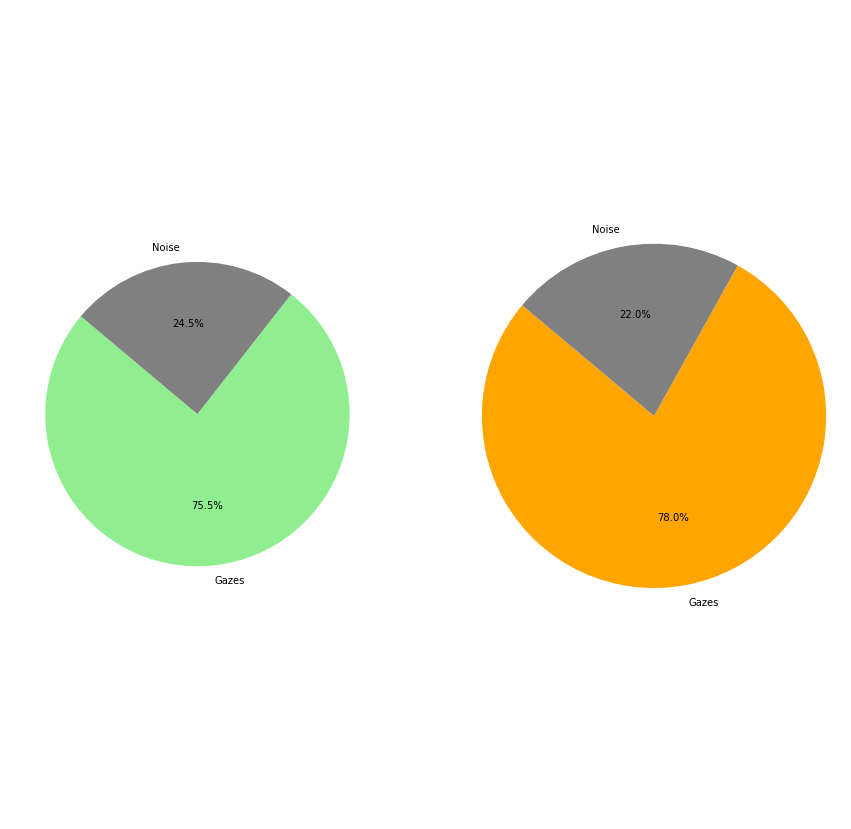

In [28]:
gazes = condense_RLE_df[condense_RLE_df.Samples>21].Samples.sum()
noise = condense_RLE_df[condense_RLE_df.Samples<21].Samples.sum()

gazes_interpolated = interpolated_data[interpolated_data.Samples>21].Samples.sum()
noise_interpolated = interpolated_data[interpolated_data.Samples<21].Samples.sum()



# Data to plot
labels = 'Gazes', 'Noise'
sizes = [gazes, noise]
colors = ['lightgreen', 'gray']
explode = (0, 0, 0, 0)  # explode 1st slice

# Data to plot after interpolation
labels_interpolated = 'Gazes', 'Noise'
sizes_interpolated = [gazes_interpolated, noise_interpolated]
colors_interpolated = ['orange', 'gray']
explode_interpolated = (0, 0, 0, 0)  # explode 1st slice


# Plot
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=False, startangle=140)

plt.subplot(1,2,2)
plt.pie(sizes_interpolated, labels=labels_interpolated, colors=colors_interpolated,
autopct='%1.1f%%', shadow=False, startangle=140)

plt.axis('equal')
plt.show()

In [159]:
condense_RLE_df[condense_RLE_df.ColliderName=='NoHouse'].Samples.sum()/condense_RLE_df[condense_RLE_df.Samples>0].Samples.sum()

0.45297855189745373

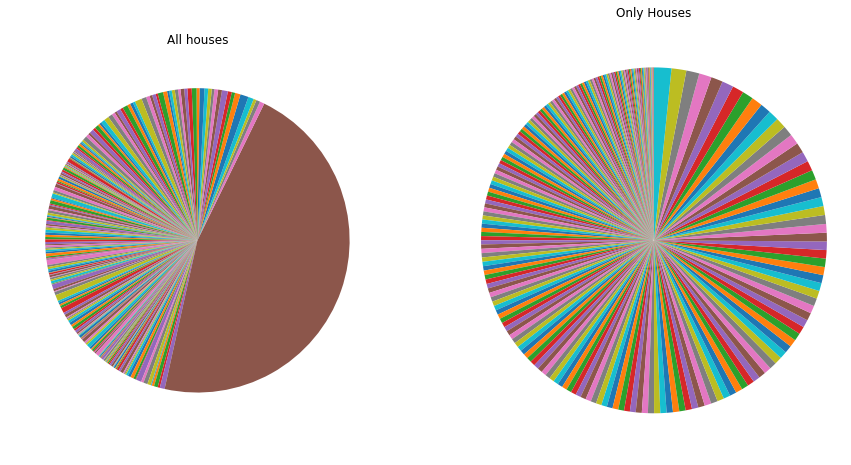

In [121]:
ColliderAppearances = interpolated_data.groupby('ColliderName').Samples.sum()

Colliders_onlyHouses = ColliderAppearances.copy()
Colliders_onlyHouses = Colliders_onlyHouses.drop(labels=['NoHouse'])
Colliders_onlyHouses = Colliders_onlyHouses.sort_values()

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.pie(ColliderAppearances, shadow=False, startangle=140)
plt.title('All houses')
plt.subplot(1,2,2)
plt.pie(Colliders_onlyHouses, shadow=False, startangle=90)
plt.title('Only Houses')

plt.axis('equal')
plt.show()

In [132]:
ColliderAppearances.sort_values()[-20:-1]

ColliderName
TaskBuilding_5     4680
TaskBuilding_1     4903
Building_194       5006
TaskBuilding_4     5126
TaskBuilding_26    5158
TaskBuilding_50    5209
NoHit              5213
TaskBuilding_24    5278
Building_176       5289
TaskBuilding_44    5372
Building_94        5547
Building_203       5577
TaskBuilding_35    5748
TaskBuilding_15    5825
TaskBuilding_13    5923
TaskBuilding_19    6330
Building_198       6597
TaskBuilding_40    7497
TaskBuilding_14    8782
Name: Samples, dtype: int64

In [29]:
sorted_interpolation = interpolated_data.groupby('ColliderName').Samples.sum().sort_values()

building14distance = (sorted_interpolation['TaskBuilding_14'] - sorted_interpolation[0:-1].mean()) / sorted_interpolation[0:-1].std()

print('The most viewed building after interpolation is currently {} sigma away from the mean!'.format(building14distance))


The most viewed building after interpolation is currently 4.225120602360796 sigma away from the mean!


(array([0.14620434, 0.03029793, 0.02205016, 0.0168939 , 0.00896594,
        0.008158  , 0.00940919, 0.00564439, 0.00510576, 0.0060652 ,
        0.00365258, 0.00325422, 0.00387701, 0.00237895, 0.0022499 ,
        0.00253605, 0.00154295, 0.0015149 , 0.00157661, 0.00108848,
        0.00112215, 0.00116142, 0.000836  , 0.00074623, 0.00090333,
        0.00063401, 0.00057229, 0.00067329, 0.00056668, 0.01031813]),
 array([1.0, 4.333333333333334, 7.666666666666667, 11.0,
        14.333333333333334, 17.666666666666668, 21.0, 24.333333333333336,
        27.666666666666668, 31.0, 34.333333333333336, 37.66666666666667,
        41.0, 44.333333333333336, 47.66666666666667, 51.0,
        54.333333333333336, 57.66666666666667, 61.0, 64.33333333333334,
        67.66666666666667, 71.0, 74.33333333333334, 77.66666666666667,
        81.0, 84.33333333333334, 87.66666666666667, 91.0,
        94.33333333333334, 97.66666666666667, 101.0], dtype=object),
 <BarContainer object of 30 artists>)

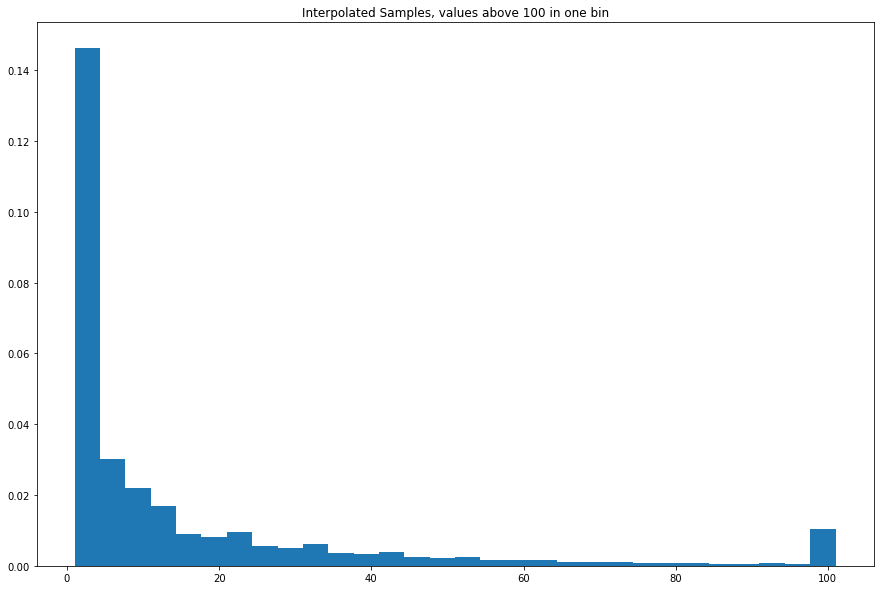

In [31]:
interpolation_til_100 = interpolated_data.copy()
interpolation_til_100 = interpolation_til_100.Samples
interpolation_til_100[interpolation_til_100>100] = 101

plt.figure(figsize=(15,10))
#plt.subplot(2,1,1)
#plt.title('Interpolated Samples, all')
#plt.hist(interpolated_data.Samples, density=True)
#plt.subplot(2,1,2)
plt.title('Interpolated Samples, values above 100 in one bin')
plt.hist(interpolation_til_100, bins= 30, density=True)

## Graph Creation
* The graph creation involves the following steps:
    * creating the edge list
        * Remove all noHouse hits 
        * Remove all noHit hits 
        * Remove all self repetitions
        * Shift the edgelist by one row and create chronology 
    * Use NetworkX to build the graph
    * Plot the graph onto the city map (using map coordinates)

In [89]:
edge_list = pd.DataFrame(columns=['Edge1','Edge2'])

transition = interpolated_data[interpolated_data.Samples>21]
transition = transition[transition.ColliderName!='NoHouse']
transition = transition[transition.ColliderName!='NoHit']

unique_count = transition.ColliderName.groupby((transition['ColliderName'] 
                                        != transition['ColliderName'].shift()).cumsum()).cumcount() + 1


edge_list.Edge1 = transition[unique_count==1].ColliderName

edge_list.reset_index(inplace=True, drop=True)

edge_list.Edge2[1:len(edge_list)-1] = edge_list.Edge1[0:len(edge_list)-2]
edge_list.loc[0, 'Edge2'] = edge_list.Edge1[len(edge_list)-1]
edge_list.loc[len(edge_list)-1, 'Edge2'] = edge_list.Edge1[0]


edge_list


,Edge1,Edge2
0,Building_161,Building_145
1,TaskBuilding_5,Building_161
2,Building_151,TaskBuilding_5
3,TaskBuilding_27,Building_151
4,Building_162,TaskBuilding_27
...,...,...
5183,TaskBuilding_33,Building_144
5184,Building_144,TaskBuilding_33
5185,Building_145,Building_144
5186,Building_147,Building_145


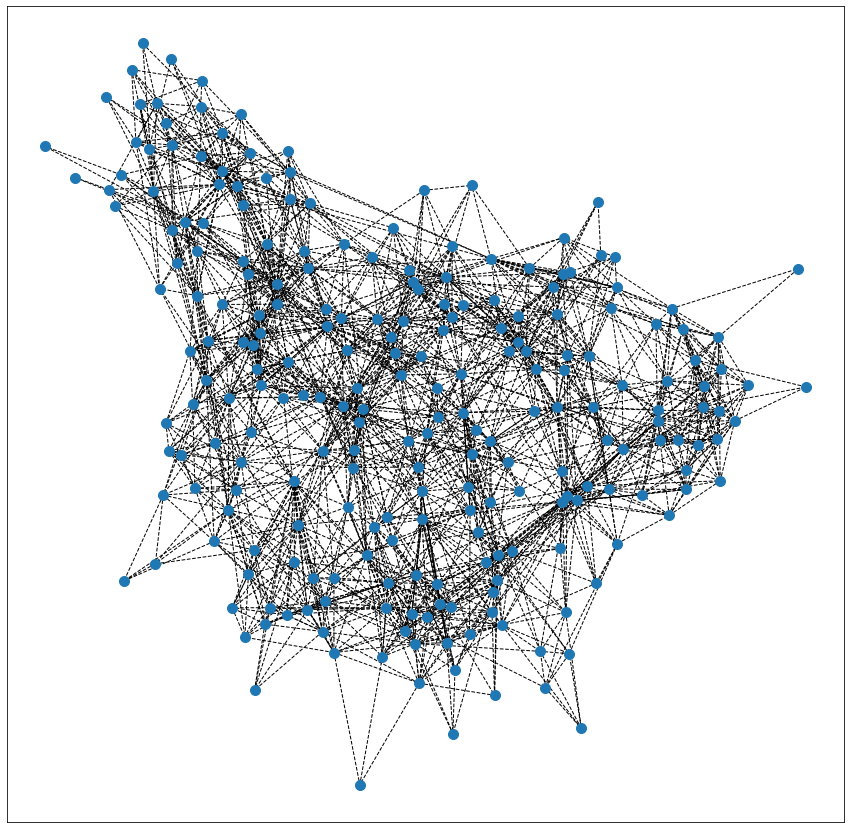

In [90]:
first_G = nx.Graph()

first_G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')

node_size = [100] * len(edge_list.Edge1)

plt.figure(figsize=(15,15))
nx.draw_networkx(first_G, with_labels=False, style='dashed', node_size=100)

my_degrees = first_G.degree
degree_values = [v for k, v in my_degrees]
#degree_values = dict(my_degrees).values()

(array([11., 14., 14., 18., 25., 26., 32., 29., 18., 18.,  9., 10.,  7.,
         2.,  4.]),
 array([ 2.        ,  4.13333333,  6.26666667,  8.4       , 10.53333333,
        12.66666667, 14.8       , 16.93333333, 19.06666667, 21.2       ,
        23.33333333, 25.46666667, 27.6       , 29.73333333, 31.86666667,
        34.        ]),
 <BarContainer object of 15 artists>)

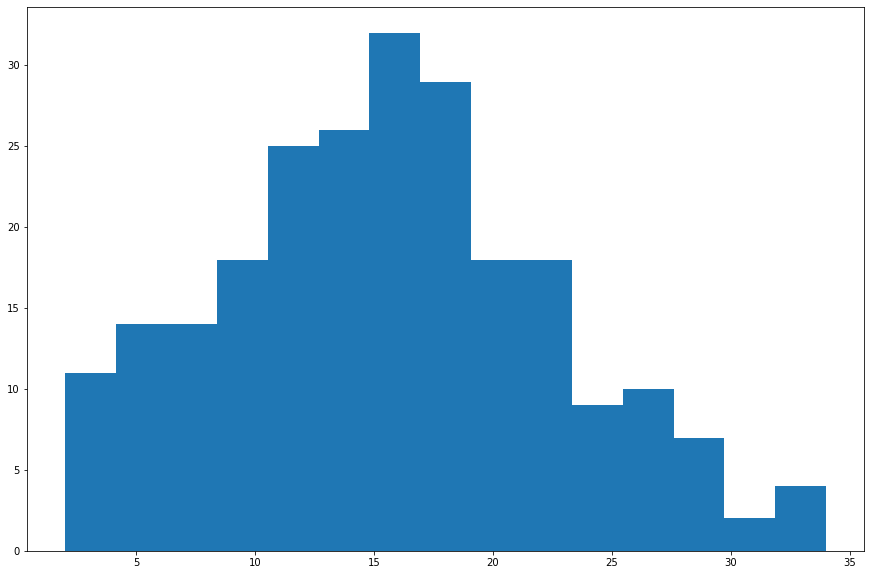

In [96]:
plt.figure(figsize=(15,10))
plt.hist(degree_values, bins=15)


In [106]:
mean_degree = np.mean(degree_values)
std_degree = np.std(degree_values)
max_degree = max(degree_values)

print('Mean/Std Degree: ' + str("{:.2f}".format(mean_degree)) + '/' + str("{:.2f}".format(std_degree)))
print('Maxmimum Degree of ' 
      + str("{:.2f}".format(max_degree)) 
      + ' is ' +
      "{:.2f}".format((max_degree-mean_degree)/std_degree)
      + ' sigma away from the mean')



Mean/Std Degree: 15.54/6.93
Maxmimum Degree of 34.00 is 2.66 sigma away from the mean
